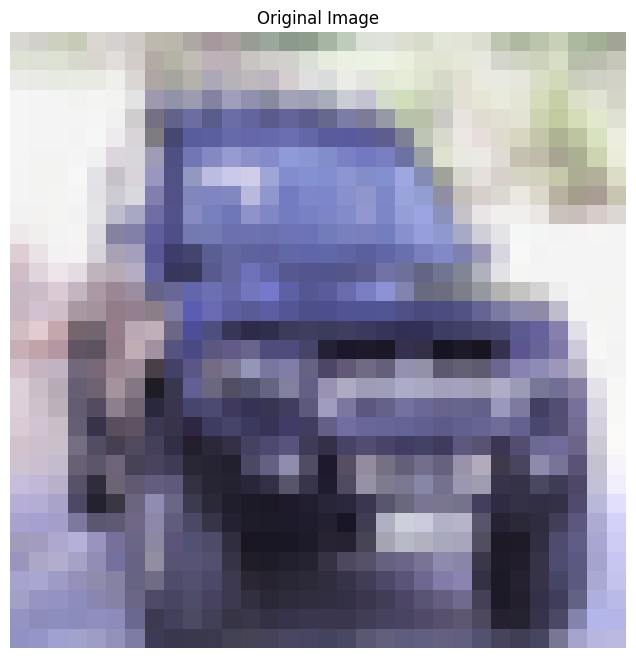

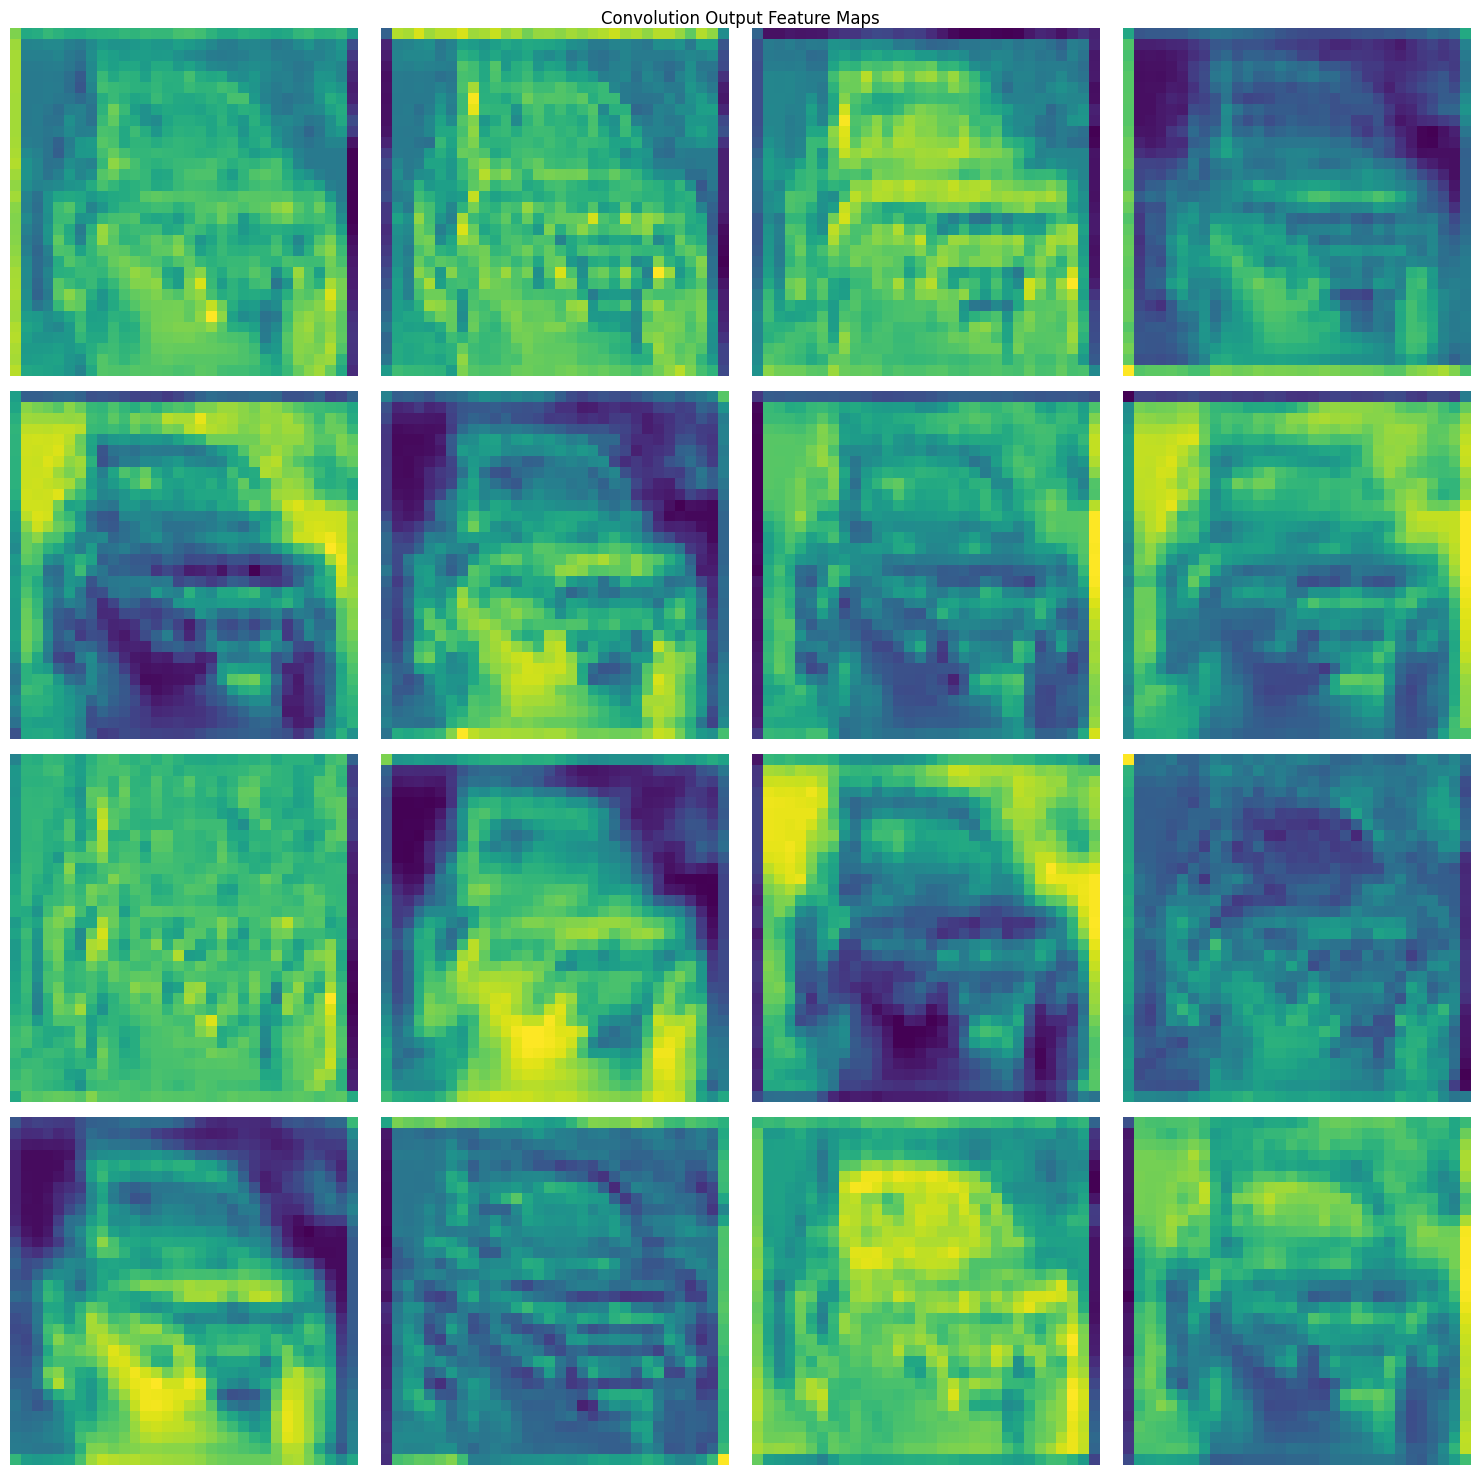

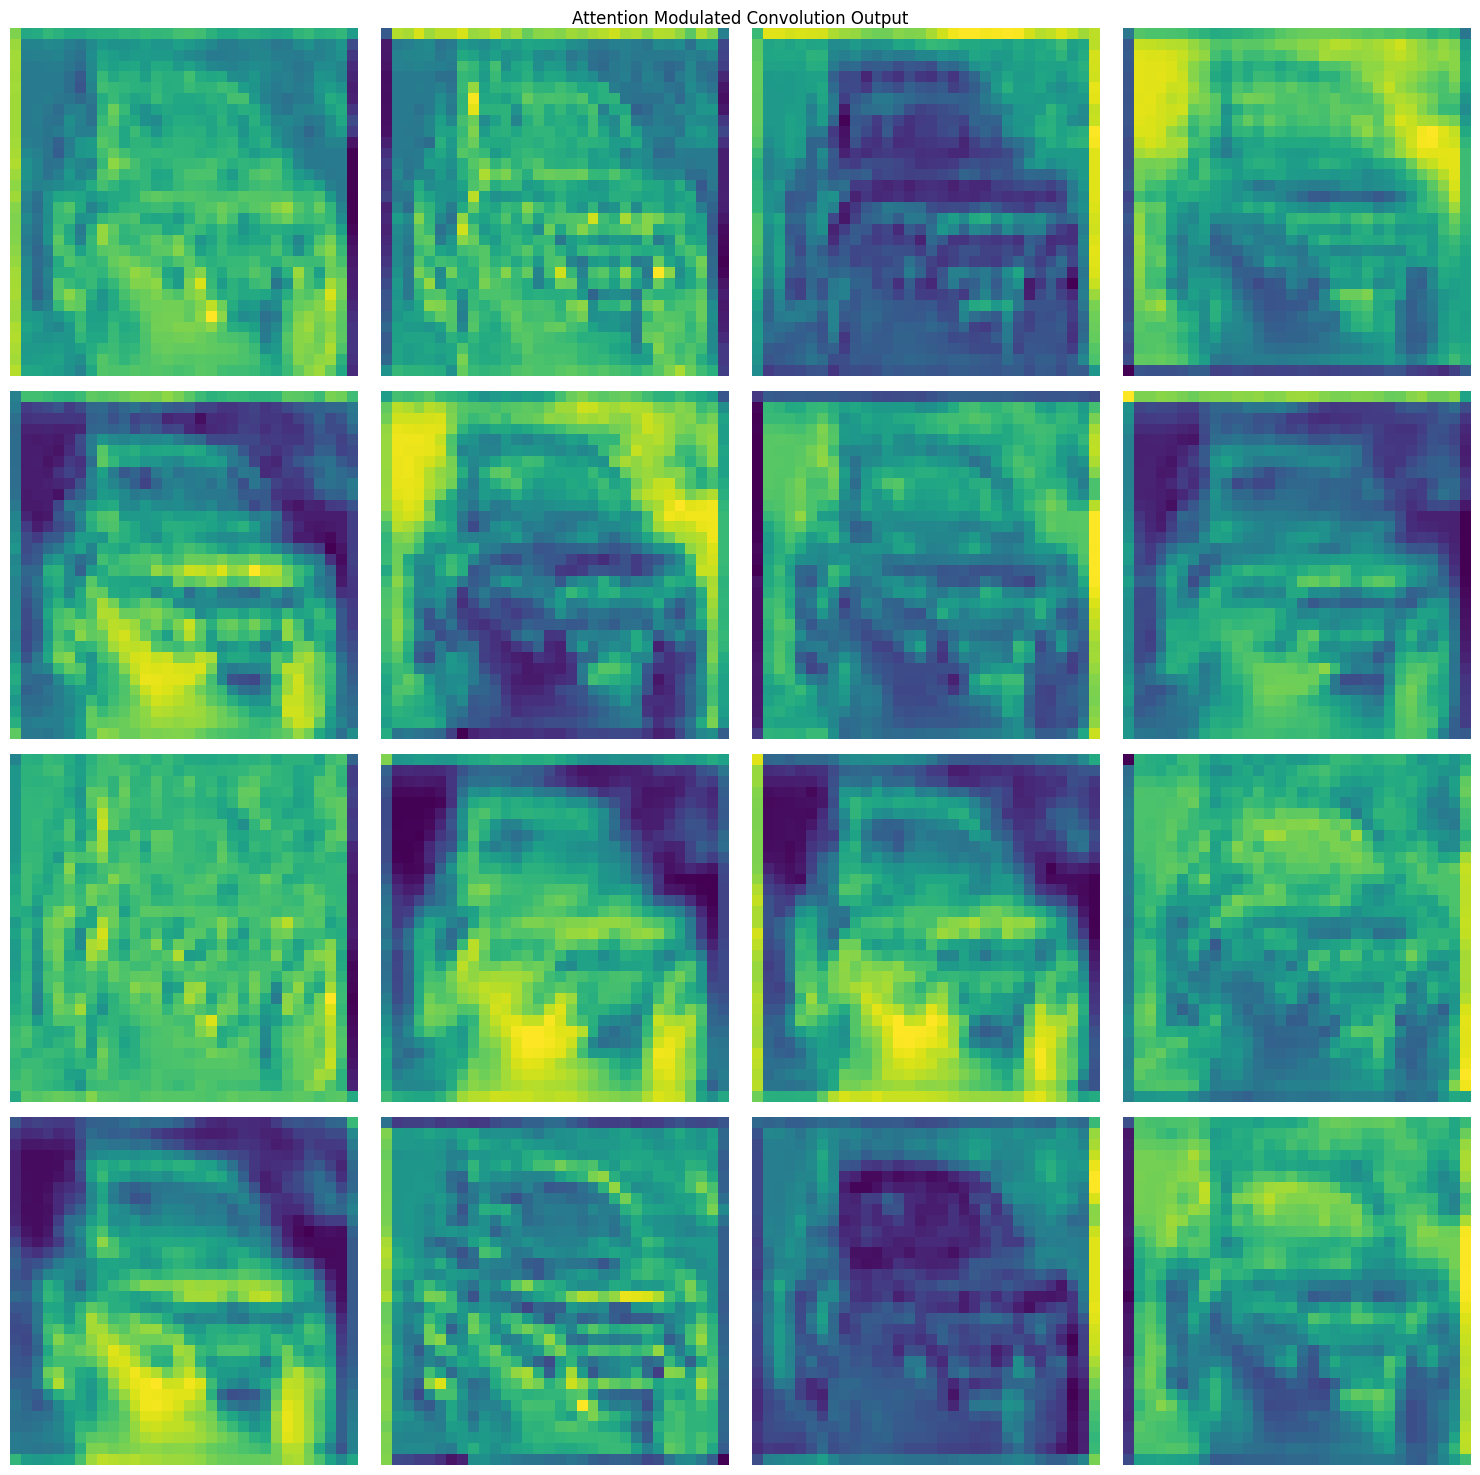

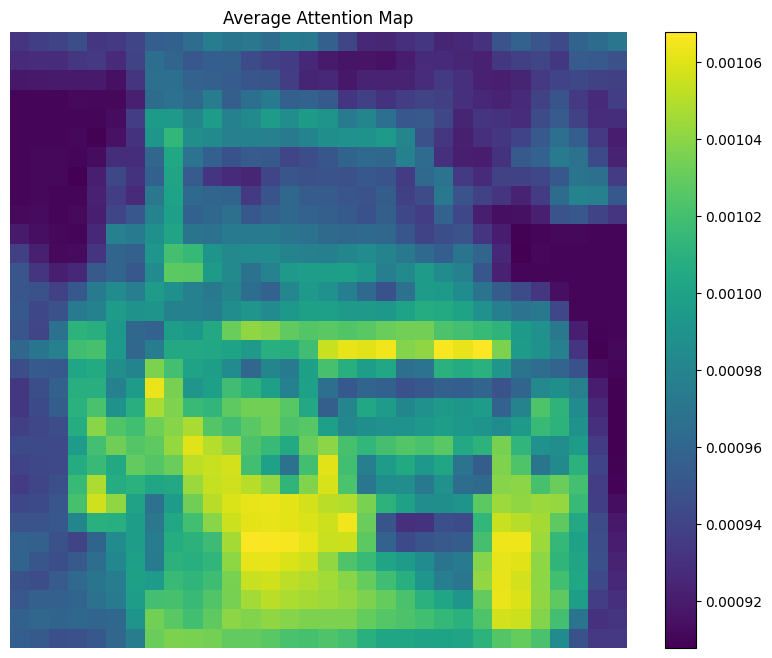

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

class ImprovedAttentionModulatedConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=1):
        super(ImprovedAttentionModulatedConv, self).__init__()
        self.query_conv = nn.Conv2d(in_channels, out_channels, 1)
        self.key_conv = nn.Conv2d(in_channels, out_channels, 1)
        self.value_conv = nn.Conv2d(in_channels, out_channels, 1)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.scale_factor = 1 / (out_channels ** 0.5)

    def forward(self, x):
        batch_size, channels, height, width = x.size()

        Q = self.query_conv(x).view(batch_size, -1, height * width)
        K = self.key_conv(x).view(batch_size, -1, height * width)
        V = self.value_conv(x).view(batch_size, -1, height * width)

        scores = torch.bmm(Q.transpose(1, 2), K) * self.scale_factor
        attention_weights = F.softmax(scores, dim=-1)

        attended_values = torch.bmm(V, attention_weights.transpose(1, 2))
        attended_values = attended_values.view(batch_size, -1, height, width)

        conv_output = self.conv(x)
        modulated_conv = attended_values * conv_output

        return modulated_conv, attention_weights, conv_output

image_path = '/kaggle/input/cifar10/cifar10/test/automobile/0002.png'
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])
image = Image.open(image_path).convert('RGB')
sample_img = transform(image).unsqueeze(0)

model = ImprovedAttentionModulatedConv(in_channels=3, out_channels=16, kernel_size=3)


with torch.no_grad():
    output, attention_weights, conv_output = model(sample_img)

def visualize_image(img_tensor, title):
    if img_tensor.dim() == 4:
        img_tensor = img_tensor.squeeze(0)
    img_np = img_tensor.permute(1, 2, 0).numpy()
    if img_np.max() <= 1:
        img_np = (img_np * 255).astype('uint8')
    plt.figure(figsize=(8, 8))
    plt.imshow(img_np)
    plt.title(title)
    plt.axis('off')
    plt.show()

def visualize_feature_maps(feature_maps, title):
    num_maps = min(16, feature_maps.size(1))
    fig, axes = plt.subplots(4, 4, figsize=(15, 15))
    for i in range(num_maps):
        ax = axes[i // 4, i % 4]
        ax.imshow(feature_maps[0, i].cpu().numpy(), cmap='viridis')
        ax.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def visualize_attention_map(attention_weights):
    att_map = attention_weights[0].reshape(32, 32, 32, 32).mean(dim=(0, 1))
    plt.figure(figsize=(10, 8))
    plt.imshow(att_map.cpu().numpy(), cmap='viridis')
    plt.title("Average Attention Map")
    plt.colorbar()
    plt.axis('off')
    plt.show()

visualize_image(sample_img, "Original Image")
visualize_feature_maps(conv_output, "Convolution Output Feature Maps")
visualize_feature_maps(output, "Attention Modulated Convolution Output")
visualize_attention_map(attention_weights)

100%|██████████| 157/157 [01:21<00:00,  1.92it/s]


Epoch 1/10, Accuracy: 44.32%


100%|██████████| 157/157 [00:14<00:00, 11.13it/s]


Epoch 2/10, Accuracy: 50.59%


100%|██████████| 157/157 [00:14<00:00, 10.95it/s]


Epoch 3/10, Accuracy: 53.34%


100%|██████████| 157/157 [00:13<00:00, 11.42it/s]


Epoch 4/10, Accuracy: 52.99%


100%|██████████| 157/157 [00:12<00:00, 12.19it/s]


Epoch 5/10, Accuracy: 54.21%


100%|██████████| 157/157 [00:11<00:00, 14.00it/s]


Epoch 6/10, Accuracy: 54.42%


100%|██████████| 157/157 [00:10<00:00, 14.35it/s]


Epoch 7/10, Accuracy: 54.98%


100%|██████████| 157/157 [00:11<00:00, 13.39it/s]


Epoch 8/10, Accuracy: 53.49%


100%|██████████| 157/157 [00:11<00:00, 13.66it/s]


Epoch 9/10, Accuracy: 55.29%


100%|██████████| 157/157 [00:11<00:00, 14.09it/s]


Epoch 10/10, Accuracy: 53.72%


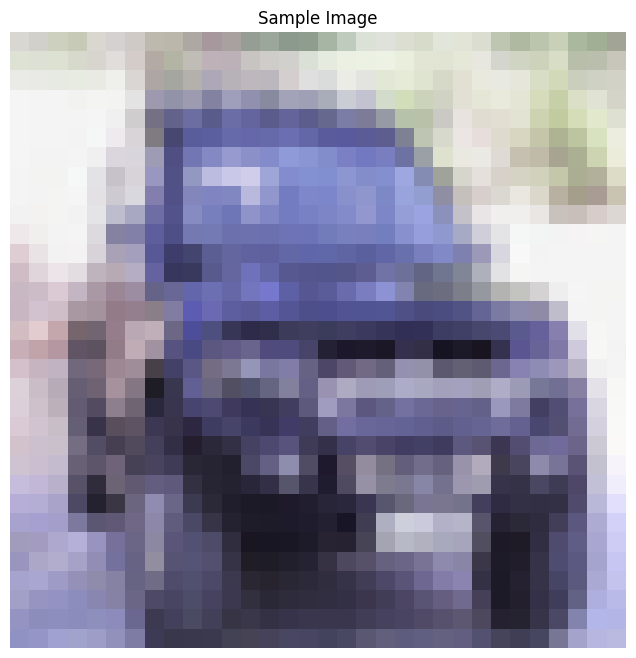

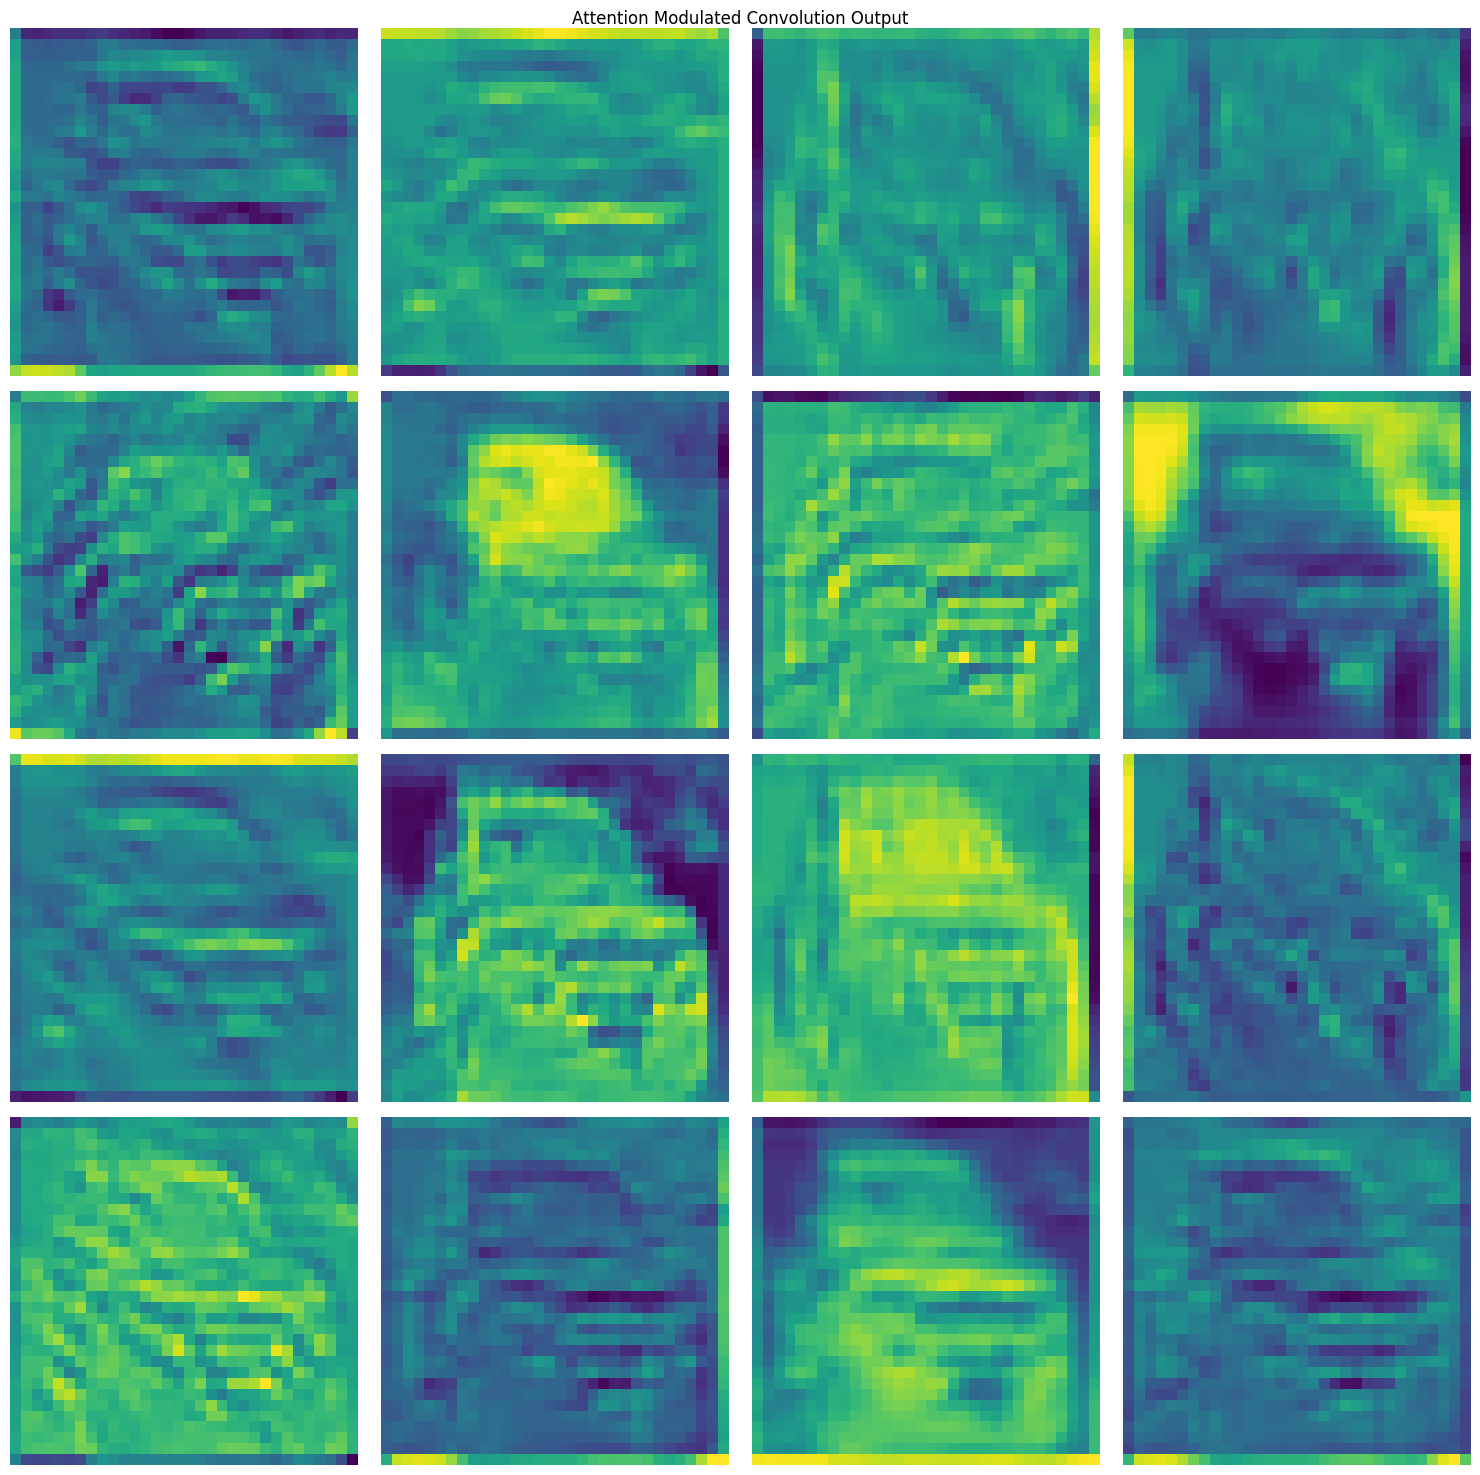

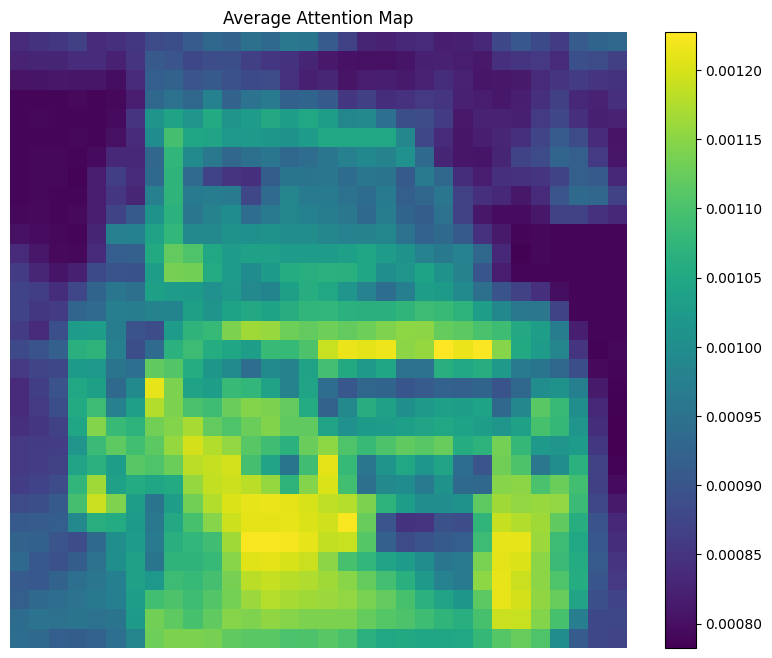

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from PIL import Image
import os

class CustomCIFAR10Dataset(Dataset):
    def __init__(self, root_dir, train=True, transform=None):
        self.root_dir = root_dir
        self.train = train
        self.transform = transform
        self.data = []
        self.targets = []
        self.classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

        dataset_dir = os.path.join(root_dir, 'train' if train else 'test')
        for class_idx, class_name in enumerate(self.classes):
            class_dir = os.path.join(dataset_dir, class_name)
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                self.data.append(img_path)
                self.targets.append(class_idx)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        target = self.targets[idx]

        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img, target

class AttentionModulatedConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=1):
        super(AttentionModulatedConv, self).__init__()
        self.query_conv = nn.Conv2d(in_channels, out_channels, 1)
        self.key_conv = nn.Conv2d(in_channels, out_channels, 1)
        self.value_conv = nn.Conv2d(in_channels, out_channels, 1)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.scale_factor = 1 / (out_channels ** 0.5)

    def forward(self, x):
        batch_size, channels, height, width = x.size()

        Q = self.query_conv(x).view(batch_size, -1, height * width)
        K = self.key_conv(x).view(batch_size, -1, height * width)
        V = self.value_conv(x).view(batch_size, -1, height * width)

        scores = torch.bmm(Q.transpose(1, 2), K) * self.scale_factor
        attention_weights = torch.softmax(scores, dim=-1)

        attended_values = torch.bmm(V, attention_weights.transpose(1, 2))
        attended_values = attended_values.view(batch_size, -1, height, width)

        conv_output = self.conv(x)
        modulated_conv = attended_values * conv_output

        return modulated_conv, attention_weights

class CIFAR10Model(nn.Module):
    def __init__(self):
        super(CIFAR10Model, self).__init__()
        self.attention_conv = AttentionModulatedConv(3, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x, attention_weights = self.attention_conv(x)
        x = self.pool(torch.relu(x))
        x = x.view(-1, 32 * 16 * 16)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x, attention_weights

# Set up data loading
transform = transforms.Compose([
    transforms.Resize((32, 32)),  
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = CustomCIFAR10Dataset(root_dir='/kaggle/input/cifar10/cifar10', train=True, transform=transform)
test_dataset = CustomCIFAR10Dataset(root_dir='/kaggle/input/cifar10/cifar10', train=False, transform=transform)

subset_size = 10000
subset_indices = torch.randperm(len(train_dataset))[:subset_size]
train_subset = Subset(train_dataset, subset_indices)

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CIFAR10Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output, _ = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs, _ = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    print(f'Epoch {epoch+1}/{num_epochs}, Accuracy: {100 * correct / total:.2f}%')

def visualize_feature_maps(feature_maps, title):
    num_maps = min(16, feature_maps.size(1))
    fig, axes = plt.subplots(4, 4, figsize=(15, 15))
    for i in range(num_maps):
        ax = axes[i // 4, i % 4]
        ax.imshow(feature_maps[0, i].cpu().numpy(), cmap='viridis')
        ax.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def visualize_attention_map(attention_weights):
    att_map = attention_weights[0].reshape(32, 32, 32, 32).mean(dim=(0, 1))
    plt.figure(figsize=(10, 8))
    plt.imshow(att_map.cpu().numpy(), cmap='viridis')
    plt.title("Average Attention Map")
    plt.colorbar()
    plt.axis('off')
    plt.show()

dataiter = iter(test_loader)
images, labels = next(dataiter)
# sample_img = images[0].unsqueeze(0).to(device)
image_path = '/kaggle/input/cifar10/cifar10/test/automobile/0002.png'
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])
image = Image.open(image_path).convert('RGB')
sample_img = transform(image).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    output, attention_weights = model.attention_conv(sample_img)

plt.figure(figsize=(8, 8))
plt.imshow(np.transpose(sample_img.cpu().squeeze().numpy(), (1, 2, 0)))
plt.title("Sample Image")
plt.axis('off')
plt.show()

visualize_feature_maps(output, "Attention Modulated Convolution Output")
visualize_attention_map(attention_weights)

Convolution modulated attention

100%|██████████| 157/157 [01:21<00:00,  1.92it/s]


Epoch 1/10, Accuracy: 28.90%


100%|██████████| 157/157 [00:15<00:00, 10.18it/s]


Epoch 2/10, Accuracy: 33.77%


100%|██████████| 157/157 [00:14<00:00, 10.77it/s]


Epoch 3/10, Accuracy: 35.79%


100%|██████████| 157/157 [00:14<00:00, 10.57it/s]


Epoch 4/10, Accuracy: 38.24%


100%|██████████| 157/157 [00:13<00:00, 11.93it/s]


Epoch 5/10, Accuracy: 40.07%


100%|██████████| 157/157 [00:11<00:00, 13.62it/s]


Epoch 6/10, Accuracy: 41.12%


100%|██████████| 157/157 [00:11<00:00, 13.95it/s]


Epoch 7/10, Accuracy: 42.62%


100%|██████████| 157/157 [00:10<00:00, 14.67it/s]


Epoch 8/10, Accuracy: 43.34%


100%|██████████| 157/157 [00:11<00:00, 14.05it/s]


Epoch 9/10, Accuracy: 44.02%


100%|██████████| 157/157 [00:11<00:00, 13.87it/s]


Epoch 10/10, Accuracy: 44.87%


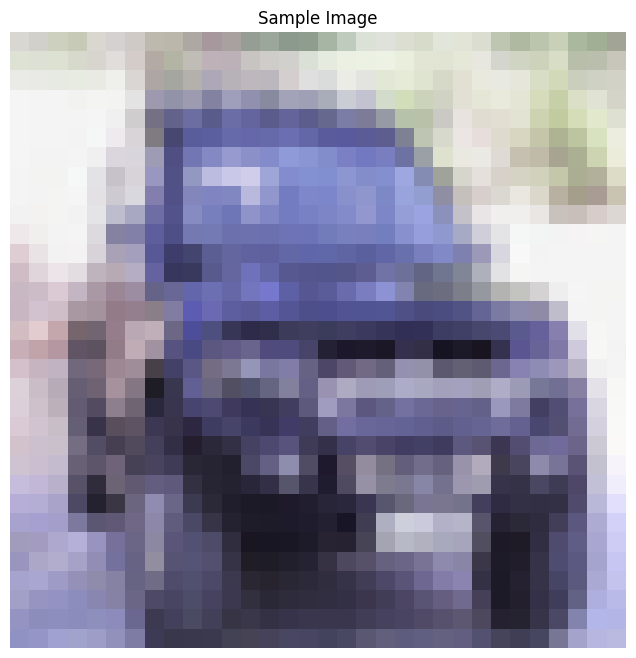

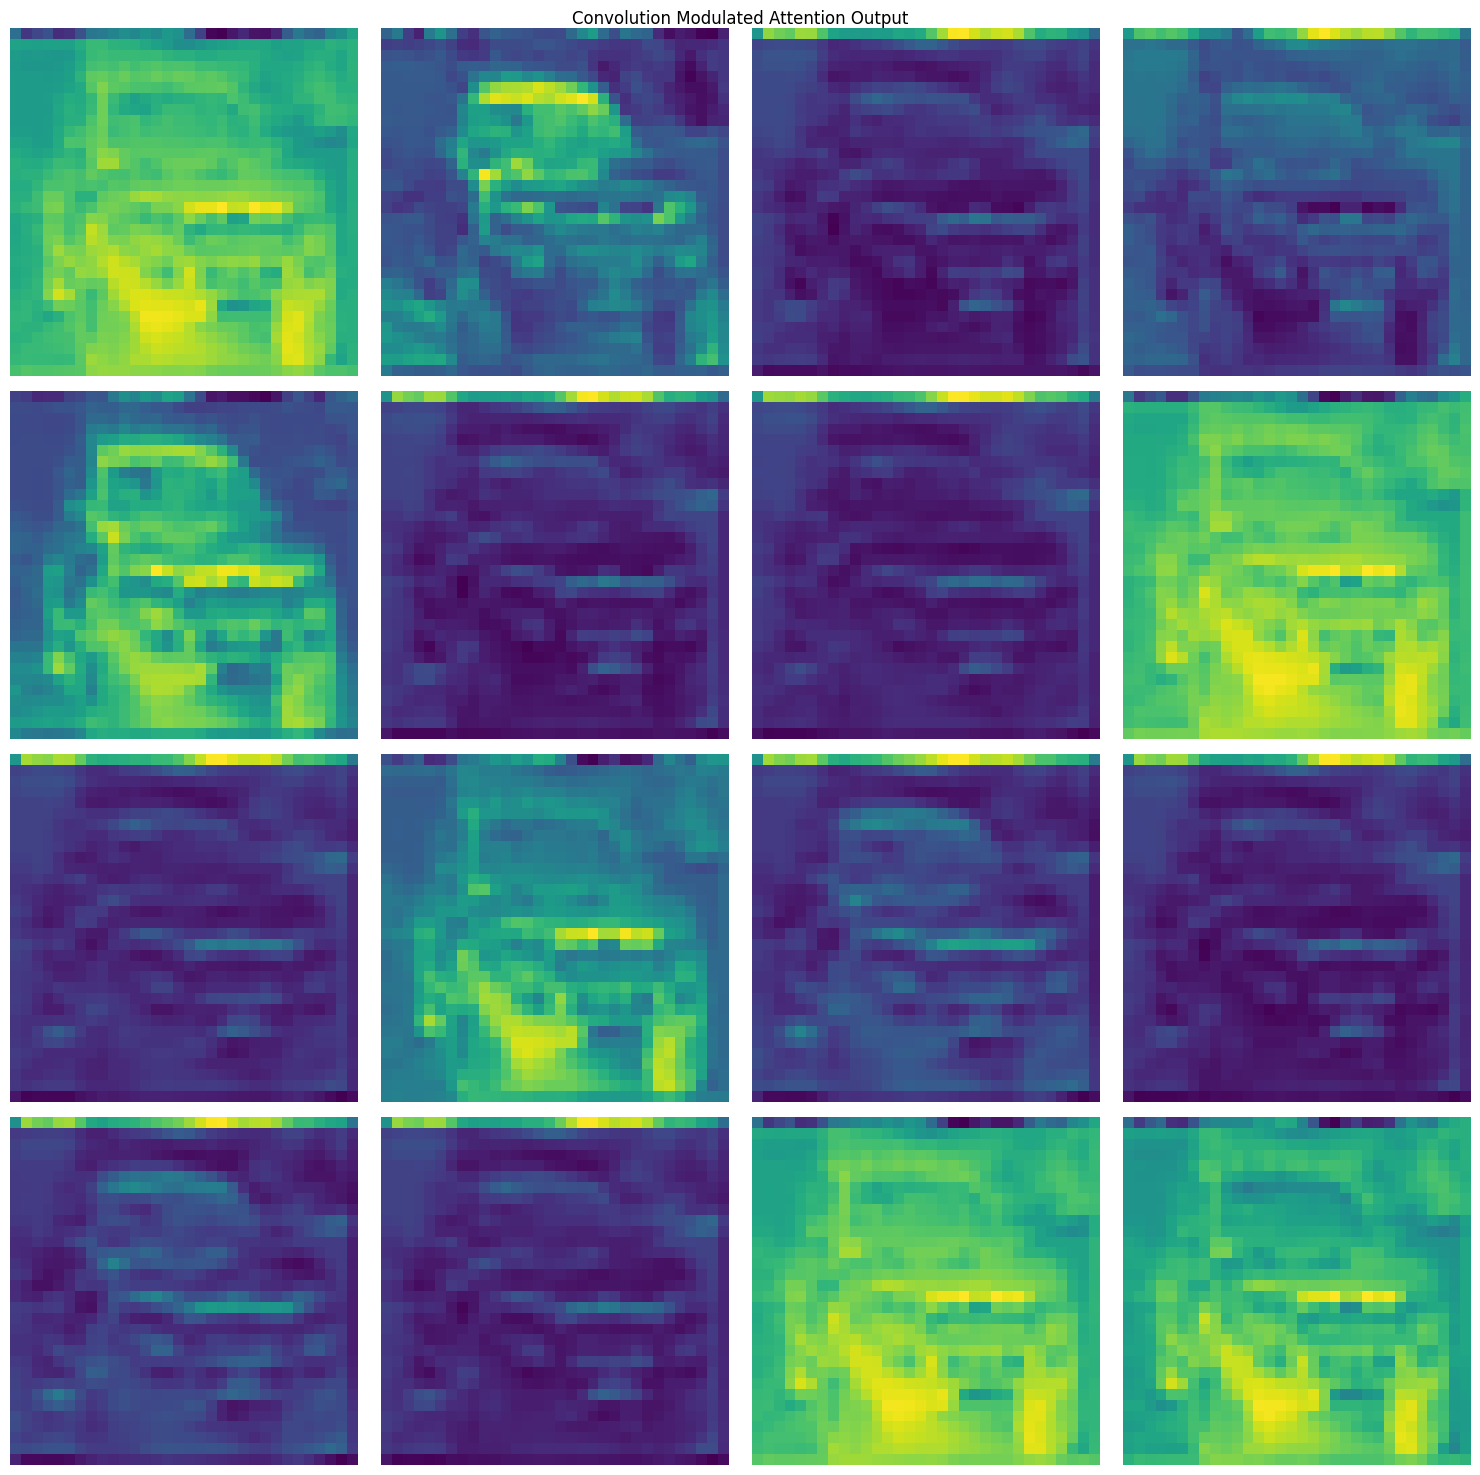

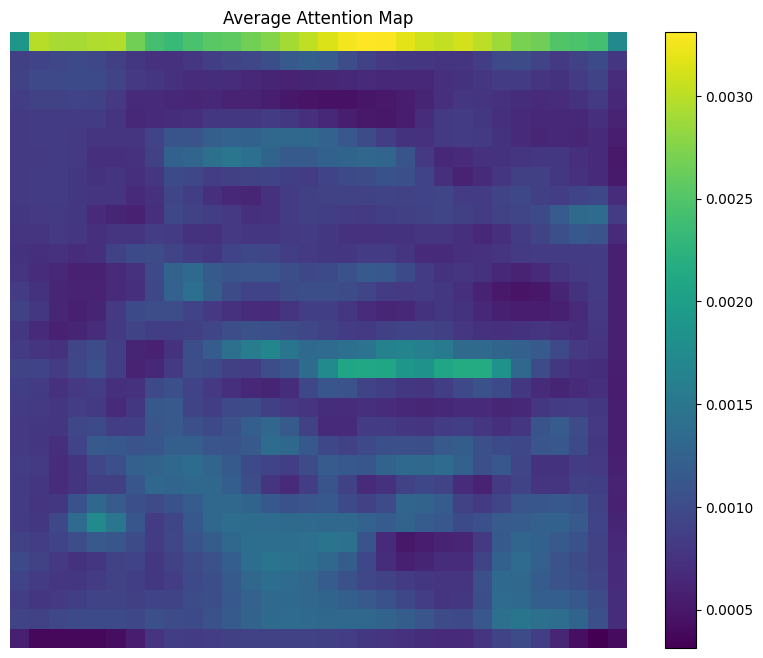

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from PIL import Image
import os
import torch.nn.functional as F

class CustomCIFAR10Dataset(Dataset):
    def __init__(self, root_dir, train=True, transform=None):
        self.root_dir = root_dir
        self.train = train
        self.transform = transform
        self.data = []
        self.targets = []
        self.classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

        dataset_dir = os.path.join(root_dir, 'train' if train else 'test')
        for class_idx, class_name in enumerate(self.classes):
            class_dir = os.path.join(dataset_dir, class_name)
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                self.data.append(img_path)
                self.targets.append(class_idx)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        target = self.targets[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, target

class ConvModulatedAttention(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=1):
        super(ConvModulatedAttention, self).__init__()
        self.dw_conv = nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding, groups=in_channels)
        self.V = nn.Conv2d(in_channels, out_channels, 1)
        self.out_channels = out_channels

    def forward(self, x):
        batch_size, _, height, width = x.size()
        dw_conv_output = self.dw_conv(x)
        attention_weights = F.softmax(dw_conv_output.view(batch_size, -1, height * width), dim=2)
        attention_weights = attention_weights.view(batch_size, -1, height, width)
        V_x = self.V(x)
        output = V_x * attention_weights.sum(dim=1, keepdim=True)

        return output, attention_weights

class CIFAR10Model(nn.Module):
    def __init__(self):
        super(CIFAR10Model, self).__init__()
        self.conv_attention = ConvModulatedAttention(3, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x, attention_weights = self.conv_attention(x)
        x = self.pool(torch.relu(x))
        x = x.view(-1, 32 * 16 * 16)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x, attention_weights

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = CustomCIFAR10Dataset(root_dir='/kaggle/input/cifar10/cifar10', train=True, transform=transform)
test_dataset = CustomCIFAR10Dataset(root_dir='/kaggle/input/cifar10/cifar10', train=False, transform=transform)

subset_size = 10000
subset_indices = torch.randperm(len(train_dataset))[:subset_size]
train_subset = Subset(train_dataset, subset_indices)

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CIFAR10Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output, _ = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs, _ = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    print(f'Epoch {epoch+1}/{num_epochs}, Accuracy: {100 * correct / total:.2f}%')

def visualize_feature_maps(feature_maps, title):
    num_maps = min(16, feature_maps.size(1))
    fig, axes = plt.subplots(4, 4, figsize=(15, 15))
    for i in range(num_maps):
        ax = axes[i // 4, i % 4]
        ax.imshow(feature_maps[0, i].cpu().numpy(), cmap='viridis')
        ax.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def visualize_attention_map(attention_weights):
    att_map = attention_weights[0].mean(dim=0)  # Averaging over channels
    plt.figure(figsize=(10, 8))
    plt.imshow(att_map.cpu().numpy(), cmap='viridis')
    plt.title("Average Attention Map")
    plt.colorbar()
    plt.axis('off')
    plt.show()

dataiter = iter(test_loader)
images, labels = next(dataiter)
# sample_img = images[0].unsqueeze(0).to(device)
image_path = '/kaggle/input/cifar10/cifar10/test/automobile/0002.png'
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])
image = Image.open(image_path).convert('RGB')
sample_img = transform(image).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    output, attention_weights = model.conv_attention(sample_img)
    
plt.figure(figsize=(8, 8))
plt.imshow(np.transpose(sample_img.cpu().squeeze().numpy(), (1, 2, 0)))
plt.title("Sample Image")
plt.axis('off')
plt.show()

visualize_feature_maps(output, "Convolution Modulated Attention Output")
visualize_attention_map(attention_weights)